(heavy_tail)=
# 重尾分布

除了Anaconda中的内容，本讲还需要以下库：

In [1]:
!pip install --upgrade yfinance pandas_datareader

我们使用以下的导入。

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm

from pandas_datareader import wb
from scipy.stats import norm, cauchy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

## 概览

重尾分布是一类能够产生"极端"结果的概率分布。

在自然科学和传统经济学教学中，重尾分布通常被视为特殊情况或非主流现象。

然而，研究表明重尾分布实际上在经济学中占据着核心地位。

事实上，经济学中的许多重要分布——可能是大多数——都具有重尾特性。

在本讲中，我们将探讨重尾分布的本质，以及为什么它们在经济分析中扮演着如此重要的角色。


### 引言：轻尾分布

大多数{doc}`常用概率分布<prob_dist>`在经典统计学和自然科学中都具有“轻尾”。

为了解释这个概念，让我们先看一些例子。

```{prf:example}
:label: ht_ex_nd

经典的例子是[正态分布](https://baike.baidu.com/item/%E6%AD%A3%E6%80%81%E5%88%86%E5%B8%83)，其密度公式为

$$ 
f(x) = \frac{1}{\sqrt{2\pi}\sigma} 
\exp\left( -\frac{(x-\mu)^2}{2 \sigma^2} \right)
\qquad
(-\infty < x < \infty)
$$

这里的两个参数 $\mu$ 和 $\sigma$ 分别代表均值和标准差。

随着 $x$ 从 $\mu$ 偏离，$f(x)$ 的值会非常快地趋向于零。
```

我们可以通过绘制密度图和展示观测值的直方图来看到这一点，如下代码所示（假设 $\mu=0$ 和 $\sigma=1$）。

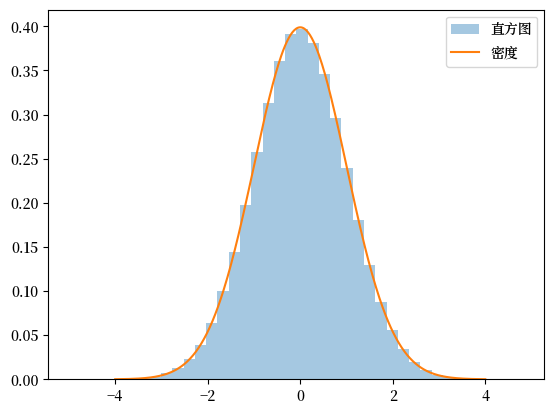

In [3]:
fig, ax = plt.subplots()
X = norm.rvs(size=1_000_000)
ax.hist(X, bins=40, alpha=0.4, label='直方图', density=True)
x_grid = np.linspace(-4, 4, 400)
ax.plot(x_grid, norm.pdf(x_grid), label='密度')
ax.legend()
plt.show()

从图中我们可以观察到两个重要特点：
* 密度函数在远离中心的区域迅速衰减
* 即使在100万个样本中，也很难观察到极端值

为了更直观地看到这一点，我们可以查看样本中的最大值和最小值：

In [4]:
X.min(), X.max()

(-4.957424561042881, 4.78943064727581)

下面是从同一分布中抽取的另一组样本：

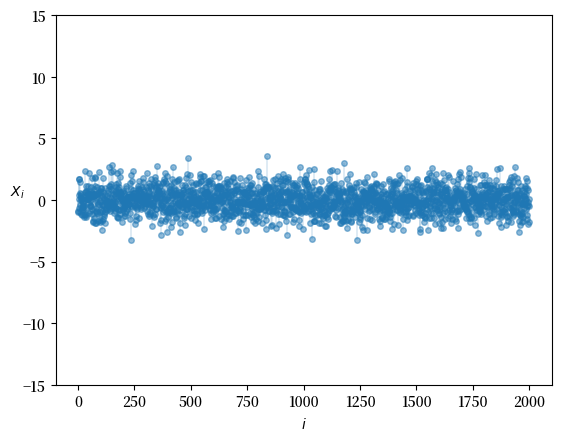

In [5]:
n = 2000
fig, ax = plt.subplots()
data = norm.rvs(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_ylim(-15, 15)
ax.set_xlabel('$i$')
ax.set_ylabel('$X_i$', rotation=0)
plt.show()

从图中可以看出，我们绘制了每个观测值 $X_i$ 随索引 $i$ 的变化情况。

注意到所有观测值都相对集中，没有特别极端的大值或小值。

这正是轻尾分布的典型特征——极端值出现的概率很低，大多数观测值都会聚集在均值附近。

简单来说，轻尾分布是那些极端事件罕见发生的分布。

（关于轻尾分布的严格数学定义，请参见{ref}`下文 <heavy-tail:formal-definition>`。）

在实际应用中，许多统计学家和计量经济学家常用"超出均值四到五个标准差的观测值可以忽略不计"这样的经验法则。

然而，这种经验法则只适用于轻尾分布的情况。

### 轻尾分布的应用场景

轻尾分布在自然界和社会现象中非常普遍。

人类身高就是一个典型的轻尾分布例子。

虽然我们确实能见到一些特别高的人，但这种情况相对罕见。

* 例如，篮球运动员[孙明明](https://baike.baidu.com/item/%E5%AD%99%E6%98%8E%E6%98%8E/4118)身高2.36米

但你肯定从未听说过有人身高达到20米、200米，更不用说2000米了，对吧？

这是为什么呢？全球有80亿人口，按理说极端情况应该会出现才对。

答案在于人类身高分布的性质——它具有非常轻的尾部，这意味着极端值出现的概率极低。实际上，人类身高几乎完美地遵循正态分布的钟形曲线。

### 资产回报率分析

那么，经济和金融数据是否也遵循同样的规律呢？

让我们先来分析一些金融市场数据。

下面我们将研究亚马逊（AMZN）股票从2015年1月1日到2022年7月1日期间的每日价格变动。

这些价格变动（不考虑股息的情况下）实际上就是投资者获得的每日回报率。

以下代码通过 `yfinance` 库使用雅虎财经数据生成所需的图表。

In [6]:
data = yf.download('AMZN', '2015-1-1', '2022-7-1', auto_adjust=False)

[*********************100%***********************]  1 of 1 completed

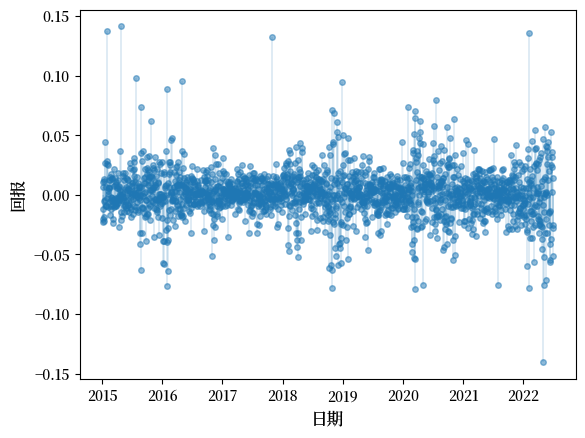

In [7]:
s = data['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('回报', fontsize=12)
ax.set_xlabel('日期', fontsize=12)

plt.show()

这些数据看起来与我们上面看到的正态分布的抽样有所不同。

有几个观测值非常极端。

如果我们查看其他资产，比如比特币，我们会得到类似的图像。

In [8]:
data = yf.download('BTC-USD', '2015-1-1', '2022-7-1', auto_adjust=False)

[*********************100%***********************]  1 of 1 completed

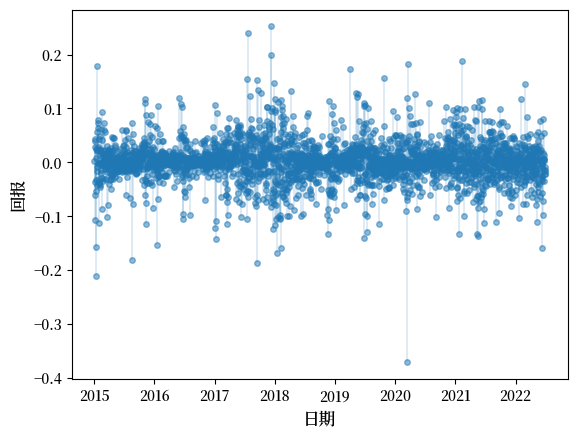

In [9]:
s = data['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('回报', fontsize=12)
ax.set_xlabel('日期', fontsize=12)

plt.show()

这个直方图也与正态分布的直方图不同:

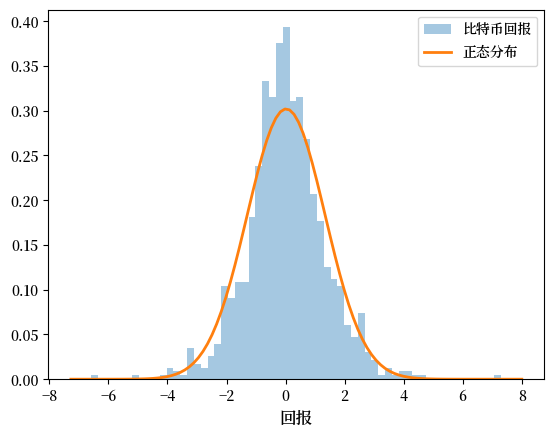

In [10]:
r = np.random.standard_t(df=5, size=1000)

fig, ax = plt.subplots()
ax.hist(r, bins=60, alpha=0.4, label='比特币回报', density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(r), np.std(r))
ax.plot(x, p, linewidth=2, label='正态分布')

ax.set_xlabel('回报', fontsize=12)
ax.legend()

plt.show()

如果我们查看更高频率的回报数据（例如，逐笔交易），我们经常会看到更极端的观测。

例如，参见 {cite}`mandelbrot1963variation` 或 {cite}`rachev2003handbook`。

### 其他数据

我们刚刚看到的数据被称为“重尾”。

在重尾分布中，极端结果相对频繁地发生。

```{prf:example}
:label: ht_ex_od

重要的是，在经济和金融中我们观察到了许多重尾分布的例子！

例如，收入和财富分布通常呈现重尾特征：

* 大多数人拥有中低水平的财富，而少数人则拥有极高的财富，形成了明显的不平等分布。

公司规模分布也表现出重尾特性：

* 经济中存在大量小型企业，同时有少数几家巨型公司占据了市场的主要份额。

城市人口分布也呈现出明显的重尾特征：

* 大多数地区是人口较少的小城镇，而少数大都市则聚集了极高比例的人口。
```

在本讲座的后续部分，我们将深入探讨这些分布中的重尾现象。

### 为什么重尾现象如此重要？

重尾分布在经济数据中普遍存在，但我们可能会问：这种现象真的值得特别关注吗？

答案是毫无疑问的！

当我们面对重尾分布时，需要重新思考许多传统的分析方法，特别是在以下方面：

* 风险管理和投资组合多样化策略
* 经济预测和模型构建
* 税收政策设计（特别是针对高度不平等的收入分布），等等。

我们将在下面回到这些 {ref}`应用 <heavy-tail:application>`。

## 视觉比较

在本节中，我们将通过直观的视觉对比来理解轻尾分布和重尾分布的区别。这有助于我们在深入数学定义之前，先建立起对这两类分布的基本认识。

随后我们会介绍一些重要概念，如帕雷托分布、互补累积分布函数和幂律，这些都是识别和分析重尾分布的关键工具。

虽然我们稍后会给出轻尾和重尾分布的严格数学定义，但先从视觉上感受它们的差异，将帮助我们更好地理解这些概念。

### 模拟

下图显示了一次模拟。

上面两个子图各显示来自正态分布的120个独立样本，这是轻尾分布。

下面的子图显示来自[柯西分布](https://en.wikipedia.org/wiki/Cauchy_distribution)的120个独立样本，这是重尾分布。

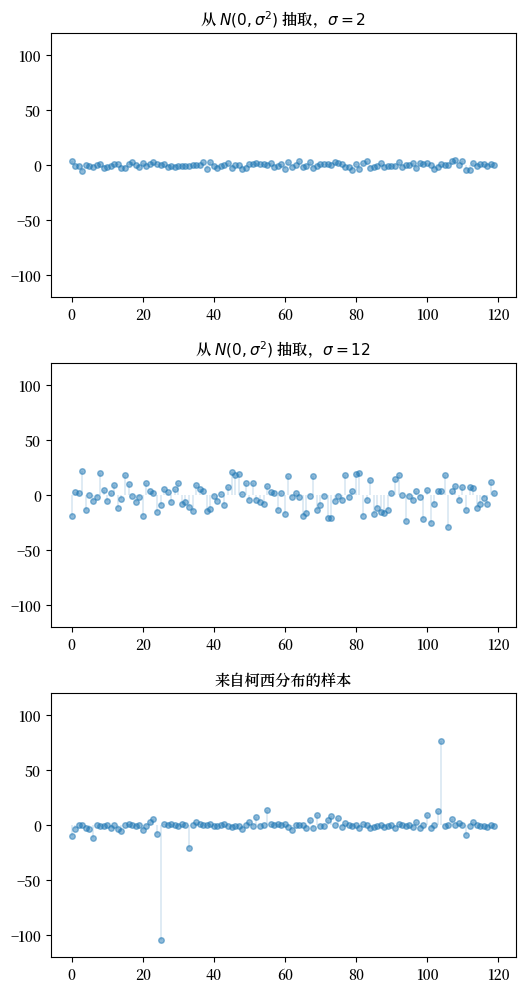

In [11]:
n = 120
np.random.seed(11)

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

for ax in axes:
    ax.set_ylim((-120, 120))

s_vals = 2, 12

for ax, s in zip(axes[:2], s_vals):
    data = np.random.randn(n) * s
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(fr"从 $N(0, \sigma^2)$ 抽取，$\sigma = {s}$", fontsize=11)

ax = axes[2]
distribution = cauchy()
data = distribution.rvs(n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_title(f"来自柯西分布的样本", fontsize=11)

plt.subplots_adjust(hspace=0.25)

plt.show()

在顶部的子图中，正态分布的标准偏差为2，样本值围绕均值聚集。

在中间的子图中，标准偏差增加到12，如预期的那样，分散度增加。

底部的子图中，柯西的样本显示出一种不同的模式：大多数观察值紧密围绕均值聚集，但偶有几个从均值突然大偏差。

这是典型的重尾分布特征。


### 非负分布

现在让我们来比较几种只取非负值的分布。

其中一种是指数分布，我们在{doc}`概率与分布讲座 <prob_dist>`中已经详细讨论过。

指数分布是典型的轻尾分布。

下面展示了从指数分布中样本的一些随机样本。

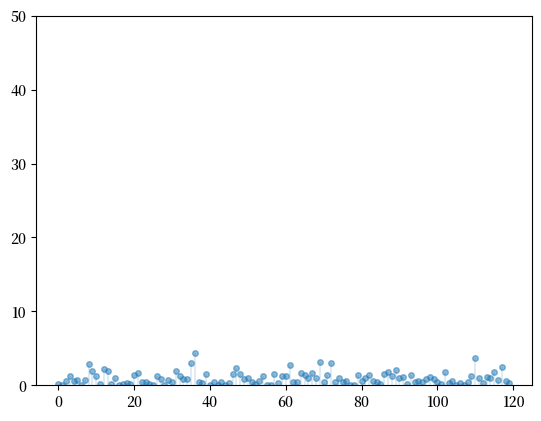

In [12]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 50))

data = np.random.exponential(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)

plt.show()

另一个非负分布是[帕累托分布](https://en.wikipedia.org/wiki/Pareto_distribution)。

对于服从帕累托分布的随机变量 $X$，存在两个正参数 $\bar{x}$ 和 $\alpha$，使得其分布函数满足

```{math}
:label: pareto

\mathbb P\{X > x\} =
\begin{cases}
    \left( \frac{\bar x}{x} \right)^{\alpha}
        & \text{ 如果 } x \geq \bar x
    \\
    1
        & \text{ 如果 } x < \bar x
\end{cases}
```

参数 $\alpha$ 被称为**尾指数**，而 $\bar x$ 则被称为**最小值**。

帕累托分布是典型的重尾分布。

生成帕累托分布的一种方法是对指数随机变量取指数。

具体来说，如果 $X$ 是一个服从参数为 $\alpha$ 的指数分布的随机变量，那么

$$
Y = \bar x \exp(X) 
$$

是一个服从帕累托分布的随机变量，其最小值为 $\bar x$，尾指数为 $\alpha$。

下面展示了从帕累托分布中抽取的样本数据，其中尾指数 $\alpha = 1$，最小值 $\bar x = 1$。

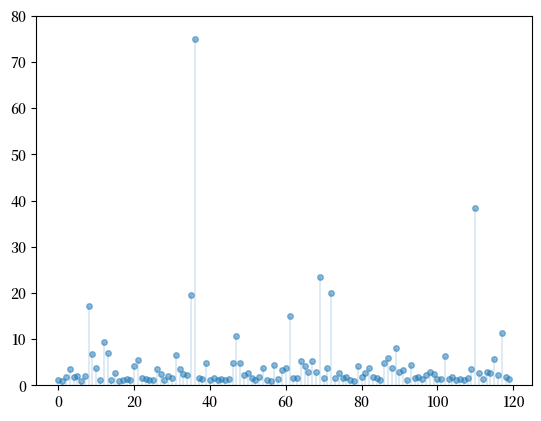

In [13]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 80))
exponential_data = np.random.exponential(size=n)
pareto_data = np.exp(exponential_data)
ax.plot(list(range(n)), pareto_data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, pareto_data, lw=0.2)

plt.show()

注意在帕累托分布中，极端结果更常见。

### 互补累积分布函数

对于非负随机变量，视觉上区分轻尾和重尾的一种方法是查看**互补累积分布函数**（CCDF）。

对于一个具有CDF $F$ 的随机变量 $X$，CCDF定义为函数

$$
G(x) := 1 - F(x) = \mathbb P\{X > x\}
$$

（有些作者称$G$为“生存”函数。）

CCDF显示随着 $x \to \infty$，上尾速度减少到零的快慢。

如果$X$是具有速率参数$\alpha$的指数分布，则其CCDF为

$$
G_E(x) = \exp(- \alpha x)
$$

随着 $x$ 增大，这个函数相对快速地趋于零。

标准帕雷托分布，其中 $\beta x = 1$，具有CCDF

$$
G_P(x) = x^{- \alpha}
$$

这个函数在 $x \to \infty$ 时趋于零，但比 $G_E$ 更慢。

```{exercise}
:label: ht_ex_x1

请证明：如果随机变量 $X$ 服从指数分布，那么 $Y = \exp(X)$ 的CCDF就是标准帕雷托分布的CCDF。
```

```{solution-start} ht_ex_x1
:class: dropdown
```

设 $G_E$ 和 $G_P$ 如上定义，设 $X$ 是具有速率参数 $\alpha$ 的指数分布，并设 $Y = \exp(X)$，我们有

$$
\begin{aligned}
 G_P(y) & = \mathbb P\{Y > y\} \\
         & = \mathbb P\{\exp(X) > y\} \\
         & = \mathbb P\{X > \ln y\} \\
         & = G_E(\ln y) \\
         & = \exp(- \alpha \ln y) \\
        & = y^{-\alpha}
\end{aligned}
$$

```{solution-end}
```

这是一个图示，展示了$G_E$比$G_P$衰减得更快。

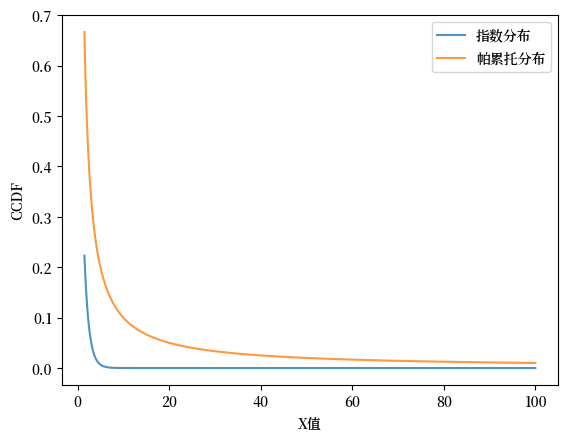

In [14]:
x = np.linspace(1.5, 100, 1000)
fig, ax = plt.subplots()
alpha = 1.0
ax.plot(x, np.exp(- alpha * x), label='指数分布', alpha=0.8)
ax.plot(x, x**(- alpha), label='帕累托分布', alpha=0.8)
ax.set_xlabel('X值')
ax.set_ylabel('CCDF')
ax.legend()
plt.show()

下面是同一函数的对数对数图，便于视觉比较。

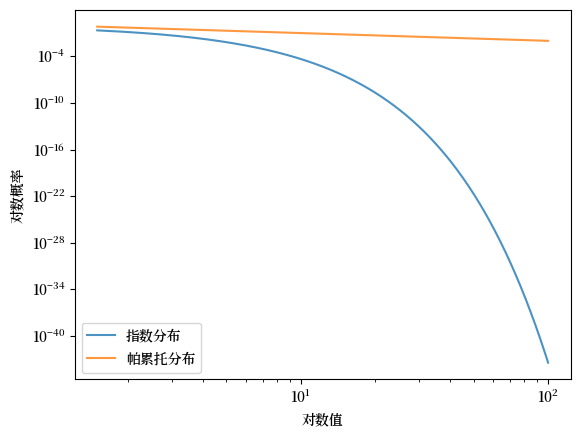

In [15]:
fig, ax = plt.subplots()
alpha = 1.0
ax.loglog(x, np.exp(- alpha * x), label='指数分布', alpha=0.8)
ax.loglog(x, x**(- alpha), label='帕累托分布', alpha=0.8)
ax.set_xlabel('对数值')
ax.set_ylabel('对数概率')
ax.legend()
plt.show()

在对数对数图中，帕累托的互补累积分布函数是线性的，而指数的则是凹的。

这个观点常用于在视觉化中区分轻尾分布和重尾分布——我们下面会再次讨论这一点。

### 经验 CCDFs

从样本数据得到的 CCDF 函数被称为**经验 CCDF**。

给定一个样本 $x_1, \ldots, x_n$，经验 CCDF 定义为

$$
\hat G(x) = \frac{1}{n} \sum_{i=1}^n \mathbb 1\{x_i > x\}
$$

因此，$\hat G(x)$ 显示样本中超过 $x$ 的比例。

In [16]:
def eccdf(x, data):
    "简单的经验 CCDF 函数。"
    return np.mean(data > x)

下面是一些从模拟数据得到的经验 CCDFs 的图。

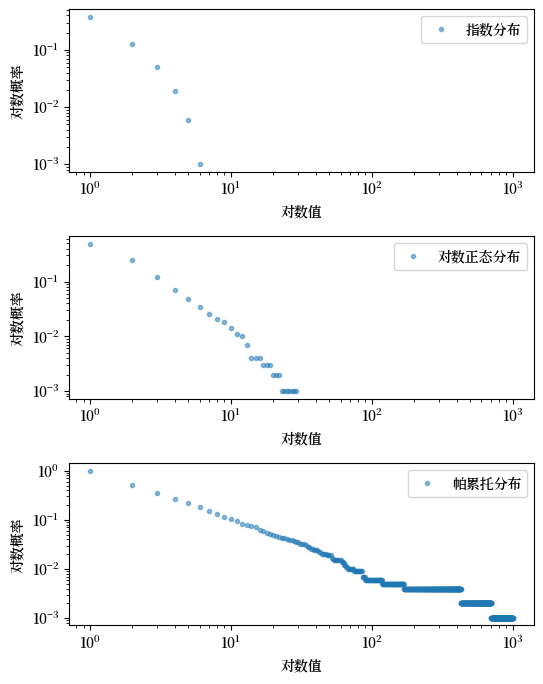

In [17]:
# 参数和网格
x_grid = np.linspace(1, 1000, 1000)
sample_size = 1000
np.random.seed(13)
z = np.random.randn(sample_size)

# 生成样本数据
data_exp = np.random.exponential(size=sample_size)
data_logn = np.exp(z)
data_pareto = np.exp(np.random.exponential(size=sample_size))

data_list = [data_exp, data_logn, data_pareto]

# 构建图形
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes = axes.flatten()
labels = ['指数分布', '对数正态分布', '帕累托分布']

for data, label, ax in zip(data_list, labels, axes):

    ax.loglog(x_grid, [eccdf(x, data) for x in x_grid], 
        'o', markersize=3.0, alpha=0.5, label=label)
    ax.set_xlabel("对数值")
    ax.set_ylabel("对数概率")
    
    ax.legend()
    
    
fig.subplots_adjust(hspace=0.4)

plt.show()

与 CCDF 一样，帕累托分布的经验 CCDF 在对数-对数图中大致呈线性。

我们将在下面使用这个想法 [here](https://intro.quantecon.org/heavy_tails.html#heavy-tails-in-economic-cross-sections) 当我们查看真实数据时。

#### Q-Q图

我们也可以使用[Q-Q图](https://baike.baidu.com/item/Q-Q%E5%9B%BE/1143751)来可视化比较两个概率分布。

[statsmodels](https://www.statsmodels.org/stable/index.html)包提供了一个方便的[qqplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html)函数，该函数默认将样本数据与正态分布的分位数进行比较。

如果数据来自正态分布，该图看起来会像：

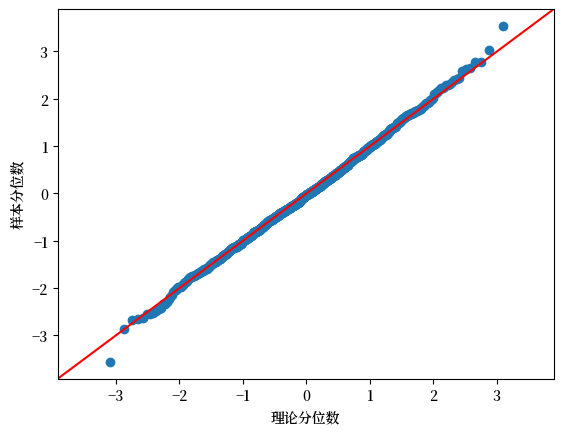

In [18]:
data_normal = np.random.normal(size=sample_size)
sm.qqplot(data_normal, line='45')
plt.xlabel("理论分位数")
plt.ylabel("样本分位数")
plt.show()

我们现在可以将其与指数分布、对数正态分布和帕累托分布进行比较

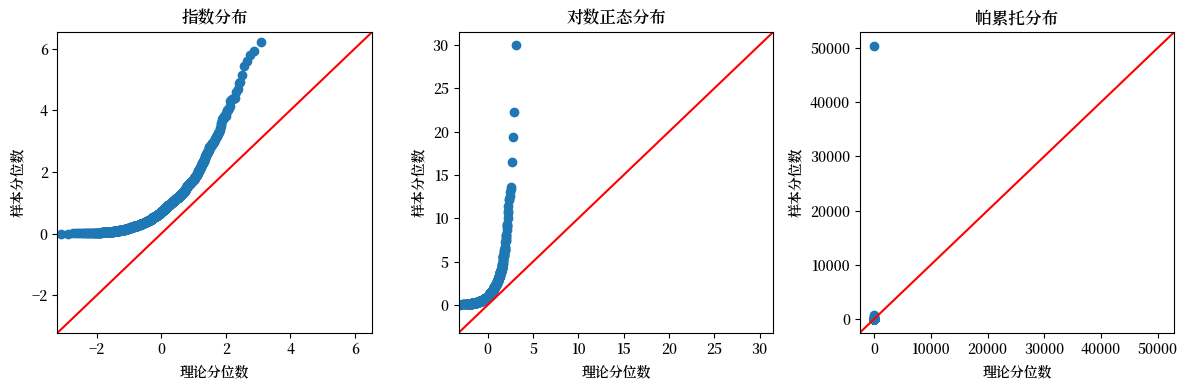

In [19]:
# 构建图形
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()
labels = ['指数分布', '对数正态分布', '帕累托分布']
for data, label, ax in zip(data_list, labels, axes):
    sm.qqplot(data, line='45', ax=ax)
    ax.set_title(label)
    ax.set_xlabel('理论分位数')
    ax.set_ylabel('样本分位数')
plt.tight_layout()
plt.show()

### 幂律

在经济和社会现象中，一类特定的重尾分布被反复发现：所谓的幂律。

若随机变量 $X$ 满足**幂律**，则存在某个 $\alpha > 0$，

```{math}
\mathbb P\{X > x\} \approx  x^{-\alpha}
\quad \text{当 $x$ 很大}
```
我们可以更数学化地写成

```{math}
:label: plrt

\lim_{x \to \infty} x^\alpha \, \mathbb P\{X > x\} = c
\quad \text{对某个 $c > 0$}
```

通常我们说具有这种性质的随机变量 $X$ 具有**帕累托尾**，其**尾指数**为 $\alpha$。

值得注意的是，所有尾指数为 $\alpha$ 的帕累托分布都具有帕累托尾，且尾指数也为 $\alpha$。

幂律可以被视为帕累托分布的一种泛化形式。这类分布在其右尾部分表现出与帕累托分布相似的特性。

另一种理解幂律的方式是将其看作一类具有特定类型重尾（通常是非常重的尾）的分布族。

## 经济数据中的重尾分布

如前所述，重尾现象在经济数据中普遍存在，而且幂律分布似乎特别常见。

为了直观展示这一点，我们将通过经验互补累积分布函数（CCDF）来观察重尾特性。

所有图表都采用对数-对数坐标系绘制，这样幂律分布在图中会呈现为直线，至少在尾部区域是如此。

我们将生成图形的代码隐藏起来，因为它相对复杂。当然，感兴趣的读者可以在查看图形后自行探索这些代码。

In [20]:
def empirical_ccdf(data, 
                   ax, 
                   aw=None,   # 权重
                   label=None,
                   xlabel=None,
                   add_reg_line=False, 
                   title=None):
    """
    接受数据向量并返回用于绘图的概率值。
    升级版的 empirical_ccdf
    """
    y_vals = np.empty_like(data, dtype='float64')
    p_vals = np.empty_like(data, dtype='float64')
    n = len(data)
    if aw is None:
        for i, d in enumerate(data):
            # 记录样本中大于 d 的分数
            y_vals[i] = np.sum(data >= d) / n
            p_vals[i] = np.sum(data == d) / n
    else:
        fw = np.empty_like(aw, dtype='float64')
        for i, a in enumerate(aw):
            fw[i] = a / np.sum(aw)
        pdf = lambda x: np.interp(x, data, fw)
        data = np.sort(data)
        j = 0
        for i, d in enumerate(data):
            j += pdf(d)
            y_vals[i] = 1- j

    x, y = np.log(data), np.log(y_vals)
    
    results = sm.OLS(y, sm.add_constant(x)).fit()
    b, a = results.params
    
    kwargs = [('alpha', 0.3)]
    if label:
        kwargs.append(('label', label))
    kwargs = dict(kwargs)

    ax.scatter(x, y, **kwargs)
    if add_reg_line:
        ax.plot(x, x * a + b, 'k-', alpha=0.6, label=f"斜率 = ${a: 1.2f}$")
    if not xlabel:
        xlabel='对数值'
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("对数概率", fontsize=12)
        
    if label:
        ax.legend(loc='lower left', fontsize=12)
        
    if title:
        ax.set_title(title)
        
    return np.log(data), y_vals, p_vals

In [21]:
def extract_wb(varlist=['NY.GDP.MKTP.CD'], 
               c='all_countries', 
               s=1900, 
               e=2021, 
               varnames=None):
    if c == "all_countries":
        # 仅保留国家（不包括汇总区域）
        countries = wb.get_countries()
        countries_name = countries[countries['region'] != 'Aggregates']['name'].values
        c = "all"
    
    df = wb.download(indicator=varlist, country=c, start=s, end=e).stack().unstack(0).reset_index()
    df = df.drop(['level_1'], axis=1).transpose()
    if varnames is not None:
        df.columns = varnames
        df = df[1:]
    
    df1 =df[df.index.isin(countries_name)]
    return df1

### 公司规模

以下是2020年来自福布斯全球2000强的最大500家公司的公司规模分布图。

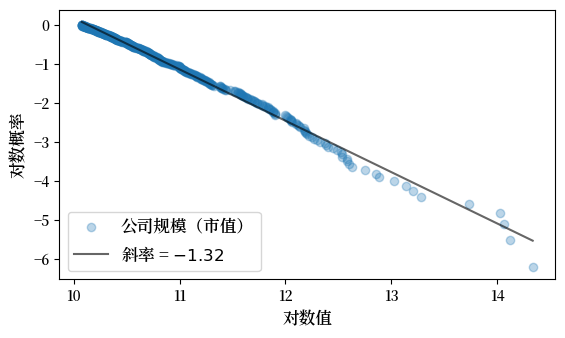

In [22]:
df_fs = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/forbes-global2000.csv')
df_fs = df_fs[['Country', 'Sales', 'Profits', 'Assets', 'Market Value']]
fig, ax = plt.subplots(figsize=(6.4, 3.5))

label="公司规模（市值）"
top = 500 # 设置排名前500的切断点
d = df_fs.sort_values('Market Value', ascending=False)
empirical_ccdf(np.asarray(d['Market Value'])[:top], ax, label=label, add_reg_line=True)

plt.show()

### 城市规模

以下是2023年来自世界人口审查的美国和巴西城市规模分布图。

大小由人口衡量。

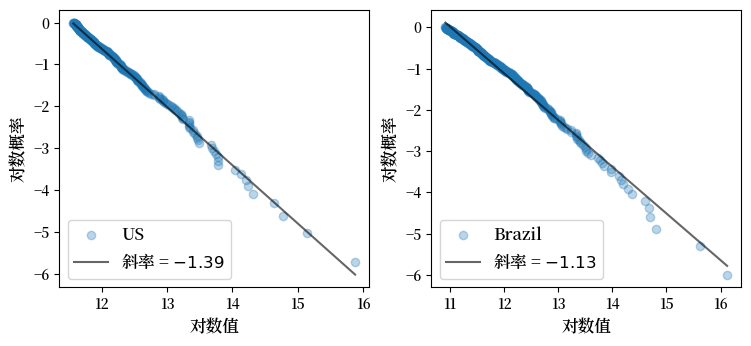

In [23]:
# 导入2023年美国和2023年巴西城市的人口数据
df_cs_us = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/cities_us.csv')
df_cs_br = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/cities_brazil.csv')

fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))

empirical_ccdf(np.asarray(df_cs_us["pop2023"]), axes[0], label="US", add_reg_line=True)
empirical_ccdf(np.asarray(df_cs_br['pop2023']), axes[1], label="Brazil", add_reg_line=True)

plt.show()

### 财富

这里是财富分布上尾部（前500名）的图表示。

数据来源于2020年的《福布斯亿万富翁》名单。

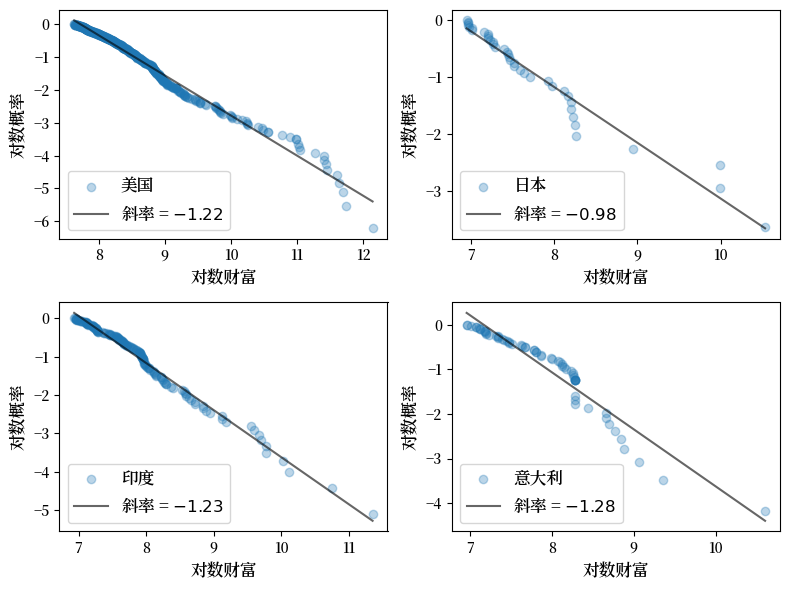

In [24]:
df_w = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/forbes-billionaires.csv')
df_w = df_w[['country', 'realTimeWorth', 'realTimeRank']].dropna()
df_w = df_w.astype({'realTimeRank': int})
df_w = df_w.sort_values('realTimeRank', ascending=True).copy()
countries = ['United States', 'Japan', 'India', 'Italy']  
country_names = ['美国', '日本', '印度', '意大利']
N = len(countries)

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

for i, c in enumerate(countries):
    df_w_c = df_w[df_w['country'] == c].reset_index()
    z = np.asarray(df_w_c['realTimeWorth'])
    # 打印来自该国的全球前2000位富豪的人数
    top = 500           # 截止数：前500名
    if len(z) <= top:    
        z = z[:top]

    empirical_ccdf(z[:top], axs[i], label=country_names[i], xlabel='对数财富', add_reg_line=True)
    
fig.tight_layout()

plt.show()

### GDP

当然，并非所有的横截面分布都是重尾的。

这里我们展示的是各国人均GDP。

In [25]:
# 获取2021年所有地区和国家的GDP及人均GDP
variable_code = ['NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']
variable_names = ['GDP', '人均GDP']

df_gdp1 = extract_wb(varlist=variable_code, 
                     c="all_countries", 
                     s="2021", 
                     e="2021", 
                     varnames=variable_names)
df_gdp1.dropna(inplace=True)

/tmp/ipykernel_6395/140199782.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=varlist, country=c, start=s, end=e).stack().unstack(0).reset_index()


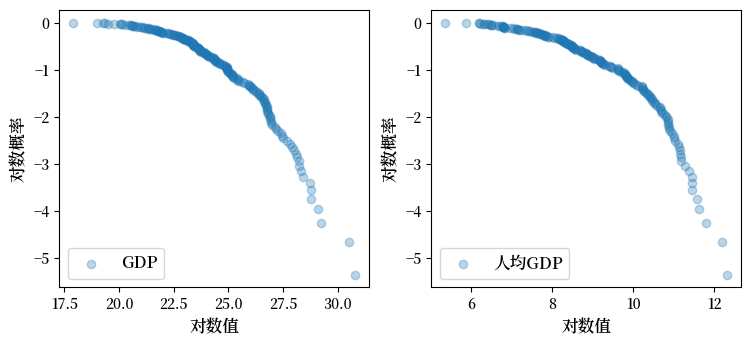

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))

for name, ax in zip(variable_names, axes):
    empirical_ccdf(np.asarray(df_gdp1[name]).astype("float64"), ax, add_reg_line=False, label=name)

plt.show()

从图中可以看出，这些曲线呈现出明显的凹形而非直线形态，表明这些分布具有轻尾特性。

这种现象的一个主要原因在于人均GDP是一个综合指标，它通过将国家总GDP除以人口数量得到，这一计算过程本质上就是一种平均处理。

当我们对数据进行平均处理时，往往会削弱或消除极端值的影响，使分布更加集中，从而导致轻尾分布的形成。


## 大数定律的失效

重尾分布的一个重要影响是样本平均值可能无法准确估计真实的总体均值。

为了理解这一点，让我们回顾{doc}`之前关于大数定律的讨论<lln_clt>`。当我们有一组独立同分布的随机变量$X_1, \ldots, X_n$，它们都服从同一分布$F$时：

如果这些随机变量的绝对期望$\mathbb E |X_i|$是有限的，那么样本平均值$\bar X_n := \frac{1}{n} \sum_{i=1}^n X_i$将会

```{math}
:label: lln_as2

\mathbb P \left\{ \bar X_n \to \mu \text{ as } n \to \infty \right\} = 1
```

其中$\mu := \mathbb E X_i = \int x F(dx)$是样本的共同均值。

在大多数情况下，条件$\mathbb E | X_i | = \int |x| F(dx) < \infty$成立，但如果分布$F$是非常重尾的，则可能不成立。

例如，柯西分布就是不成立的。

让我们来看看这种情况下样本平均值的行为，看是否大数定律仍然有效。

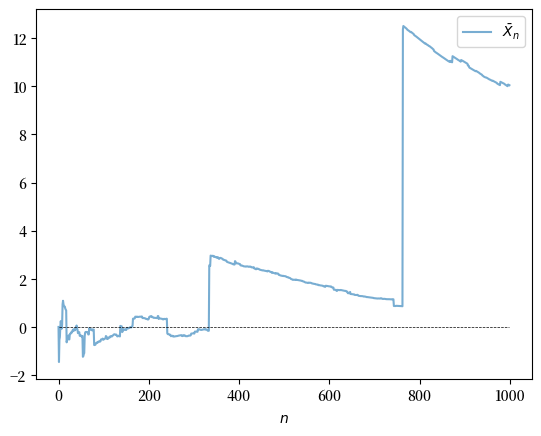

In [27]:
from scipy.stats import cauchy

np.random.seed(1234)
N = 1_000

distribution = cauchy()

fig, ax = plt.subplots()
data = distribution.rvs(N)

# 计算每个n的样本平均值
sample_mean = np.empty(N)
for n in range(1, N):
    sample_mean[n] = np.mean(data[:n])

# 绘图
ax.plot(range(N), sample_mean, alpha=0.6, label='$\\bar{X}_n$')
ax.plot(range(N), np.zeros(N), 'k--', lw=0.5)
ax.set_xlabel(r"$n$")
ax.legend()

plt.show()

序列显示没有收敛的迹象。

我们在练习中会回到这一点。


(heavy-tail:application)=
## 为什么重尾分布很重要？

我们已经看到

1. 在经济学中，重尾分布非常常见；
2. 当尾部非常重时，大数定律失效。

但是在现实世界中，重尾分布重要吗？让我们简要讨论一下它们为什么重要。

### 分散化投资

投资中一个最重要的概念是使用分散化来降低风险。

这是一个非常古老的想法——例如，考虑这个表达式“不要把所有的鸡蛋放在一个篮子里”。

为了说明这一点，设想一个拥有一美元财富的投资者，在$n$种资产中进行选择，这些资产的回报为$X_1, \ldots, X_n$。

假设不同资产的回报是独立的，每个回报有均值$\mu$和方差$\sigma^2$。

如果投资者将所有财富投资在一个资产上，那么该投资组合的预期收益为$\mu$，方差为$\sigma^2$。

如果投资者将她的财富均分到每一个资产上，即每个资产的份额为$1/n$，那么投资组合的收益为

$$
Y_n = \sum_{i=1}^n \frac{X_i}{n} = \frac{1}{n} \sum_{i=1}^n X_i.
$$

试着计算均值和方差。

你会发现：

* 均值保持不变，依旧是$\mu$，
* 投资组合的方差降低到了$\sigma^2 / n$。

正如我们所预期的，分散化投资确实能够降低风险。

然而，这里隐藏着一个重要假设：资产回报的方差必须是有限的。

当我们面对重尾分布且方差无限的情况时，上述分散化逻辑就不再成立了。

以柯西分布为例，我们前面已经看到，如果每个$X_i$都服从柯西分布，那么它们的平均值$Y_n$仍然服从相同的柯西分布。

这就意味着，无论你将投资分散到多少资产中，风险水平都不会降低！

### 财政政策

财富和收入分配的尾部特性对制定有效的税收和再分配政策具有重要影响。

当社会中存在极端的财富集中现象时，传统的税收政策可能需要重新设计才能实现预期的社会效果。

例如，了解收入分配尾部的厚重程度能够帮助政策制定者更好地设计{doc}`税收政策 <mle>`，使其既能促进公平又不过度抑制经济活力。

(cltail)=
## 分类尾部特性

虽然我们已经讨论了轻尾和重尾分布的概念，但到目前为止还没有给出它们的严格数学定义。

接下来，我们将填补这一空白，提供这些概念的精确定义。

在本节中，我们将主要关注非负随机变量分布的右侧尾部特性。

尽管左侧尾部的定义与右侧类似，但为了使讨论更加清晰简洁，我们将专注于右尾分析。

(heavy-tail:formal-definition)=
### 轻尾和重尾

一个在 $\mathbb R_+$ 上有密度 $f$ 的分布 $F$ 被称为[重尾](https://baike.baidu.com/item/%E9%87%8D%E5%B0%BE%E5%88%86%E5%B8%83/4483429)的，如果

```{math}
:label: defht

\int_0^\infty \exp(tx) f(x) dx = \infty \; \text{ 对于所有 } t > 0.
```

我们说一个非负随机变量 $X$ 是**重尾**的，如果它的分布密度是重尾的。

这等价于说它的**矩生成函数** $m(t) := \mathbb E \exp(t X)$ 对于所有 $t > 0$ 都不存在（即无限）。

例如，[对数正态分布](https://baike.baidu.com/item/%E5%AF%B9%E6%95%B0%E6%AD%A3%E6%80%81%E5%88%86%E5%B8%83/8976782)是重尾的，因为它的矩生成函数在 $(0, \infty)$ 上无限。

帕累托分布也是重尾分布的一个例子。

直观地说，重尾分布的尾部衰减速度比指数分布慢，不受指数型界限的约束。

如果一个在 $\mathbb R_+$ 上的分布 $F$ 不是重尾的，我们就称它为**轻尾**分布。

相应地，一个非负随机变量 $X$ 是**轻尾的**，如果它的分布 $F$ 是轻尾的。

所有有界支撑的随机变量都是轻尾的（想一想为什么会这样）。

例如，所有有界支撑的随机变量都是轻尾的。（为什么？）

再举一个例子，如果 $X$ 有[指数分布](https://baike.baidu.com/item/%E6%8C%87%E6%95%B0%E5%88%86%E5%B8%83%E6%A6%82%E7%8E%87%E5%AF%86%E5%BA%A6%E5%87%BD%E6%95%B0/19524913)，累积分布函数 $F(x) = 1 - \exp(-\lambda x)$ 对某个 $\lambda > 0$，则其矩生成函数为

$$
m(t) = \frac{\lambda}{\lambda - t} \quad \text{当 } t < \lambda 
$$

特别地，只要 $t < \lambda$，$m(t)$ 就是有限的，因此 $X$ 是轻尾的。

可以证明，如果 $X$ 是轻尾的，那么它的所有[矩](https://baike.baidu.com/item/%E7%9F%A9/22856460)都是有限的。

反过来说，如果某个矩是无限的，那么 $X$ 必定是重尾的。

但需要注意的是，重尾分布并不一定有无限矩。例如，对数正态分布是重尾的，但它的所有矩都是有限的。


## 延伸阅读

想了解更多关于财富分布中的重尾，可以参考文献 {cite}`pareto1896cours` 和 {cite}`benhabib2018skewed`。

想了解更多关于公司规模分布中的重尾，可以参考文献 {cite}`axtell2001zipf`, {cite}`gabaix2016power`。

想了解更多关于城市规模分布中的重尾，可以参考文献 {cite}`rozenfeld2011area`, {cite}`gabaix2016power`。

重尾的其他重要影响，除了上述讨论之外，还有不少。

例如，收入和财富中的重尾会影响生产力增长、商业周期和政治经济学。

欲了解更多，请参阅 {cite}`acemoglu2002political`, {cite}`glaeser2003injustice`, {cite}`bhandari2018inequality` 或 {cite}`ahn2018inequality`。


## 练习


```{exercise}
:label: ht_ex2

证明：如果 $X$ 拥有尾指数为 $\alpha$ 的帕累托尾，则
$\mathbb E[X^r] = \infty$ 对所有的 $r \geq \alpha$ 都成立。
```

```{solution-start} ht_ex2
:class: dropdown
```

设 $X$ 拥有尾指数为 $\alpha$ 的帕累托尾，并且设 $F$ 为其累积分布函数。

固定 $r \geq \alpha$。

根据公式 {eq}`plrt`，我们可以取正常数 $b$ 和 $\bar x$，使得

$$
\mathbb P\{X > x\} \geq b x^{-\alpha} \text{ 当 } x \geq \bar x
$$

但是

$$
\mathbb E X^r = r \int_0^\infty x^{r-1} \mathbb P\{ X > x \} dx
\geq
r \int_0^{\bar x} x^{r-1} \mathbb P\{ X > x \} dx
+ r \int_{\bar x}^\infty  x^{r-1} b x^{-\alpha} dx.
$$

我们知道 $\int_{\bar x}^\infty x^{r-\alpha-1} dx = \infty$ 当 $r - \alpha - 1 \geq -1$ 时。

由于 $r \geq \alpha$，我们得到 $\mathbb E X^r = \infty$。

```{solution-end}
```

```{exercise}
:label: ht_ex3

重复练习1，但将三个分布（两个正态，一个柯西）替换为三个帕累托分布，并使用不同的 $\alpha$ 值。

对于 $\alpha$，尝试1.15、1.5和1.75。

使用 `np.random.seed(11)` 来设置种子。
```


```{solution-start} ht_ex3
:class: dropdown
```

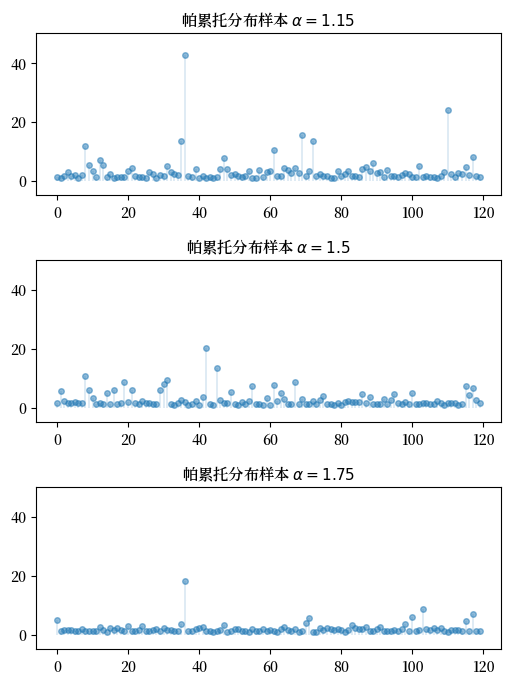

In [28]:
from scipy.stats import pareto

np.random.seed(11)

n = 120
alphas = [1.15, 1.50, 1.75]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))

for (a, ax) in zip(alphas, axes):
    ax.set_ylim((-5, 50))
    data = pareto.rvs(size=n, scale=1, b=a)
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"帕累托分布样本 $\\alpha = {a}$", fontsize=11)

plt.subplots_adjust(hspace=0.4)

plt.show()

```{solution-end}
```

```{exercise}
:label: ht_ex5

关于企业规模分布应该用帕累托分布还是对数正态分布进行建模的争论一直持续不断（参见例如 {cite}`fujiwara2004pareto`、{cite}`kondo2018us` 或 {cite}`schluter2019size`）。

这个问题虽然看起来理论性很强，但实际上对经济政策制定有着重要影响。

让我们通过一个具体例子来说明：假设我们有一个经济体，包含100,000家企业，市场利率为5%，企业所得税率为15%。

我们想要预测未来10年的企业税收收入（按现值计算）。由于这是预测，我们需要建立一个模型。

我们的模型基于两个简化假设：

1. 企业数量和规模分布（按利润计算）在这10年内保持稳定
2. 企业规模分布可以用对数正态分布或帕累托分布来描述

计算税收现值的步骤如下：

1. 从选定的分布中抽取100,000个样本，代表各企业的利润
2. 对每个利润值应用15%的税率
3. 将所有税收按5%的利率折现并求和，得到总现值

对于帕累托分布，我们使用 {eq}`pareto` 中的形式，参数设为 $\bar x = 1$ 和 $\alpha = 1.05$（这个尾指数值与实证研究 {cite}`gabaix2016power` 的发现一致）。

为了公平比较，我们需要选择对数正态分布的参数，使其均值和中位数与帕累托分布相匹配。

由于抽样的随机性，每次模拟都会产生不同的税收估计。为了获得稳健的结果，我们将对每种分布进行100次独立模拟，然后比较这两组估计值：

* 制作一张将两个样本并排显示的小提琴图，并且
* 输出两个样本的均值和标准差。

对种子使用 `np.random.seed(1234)`。

你观察到了哪些差异？

（注：解决这个问题的更好方法将是建模企业动态并尝试给定当前分布追踪个别企业。我们将在后续讲座中讨论企业动态。）
```

```{solution-start} ht_ex5
:class: dropdown
```

首先，我们需要确定对数正态分布的参数 $\mu$ 和 $\sigma$，使其与帕累托分布的均值和中位数相匹配。

对数正态分布可以表示为 $\exp(\mu + \sigma Z)$，其中 $Z$ 是标准正态随机变量。

对于帕累托分布 {eq}`pareto`，当 $\bar x = 1$ 时，其均值和中位数分别为

$$
\text{均值} = \frac{\alpha}{\alpha - 1}
\quad \text{和} \quad
\text{中位数} = 2^{1/\alpha}
$$

使用对应的对数正态分布表达式，我们得到以下方程组

$$
\frac{\alpha}{\alpha - 1} = \exp(\mu + \sigma^2/2)
\quad \text{和} \quad
2^{1/\alpha} = \exp(\mu)
$$

我们用 $\alpha = 1.05$ 来解这些方程得到 $\mu$ 和 $\sigma$。

以下是生成两个样本、制作小提琴图并打印两个样本的均值和标准差的代码。

In [29]:
num_firms = 100_000
num_years = 10
tax_rate = 0.15
r = 0.05

β = 1 / (1 + r)    # 折现因子

x_bar = 1.0
α = 1.05

def pareto_rvs(n):
    "使用标准方法生成Pareto抽样。"
    u = np.random.uniform(size=n)
    y = x_bar / (u**(1/α))
    return y

我们来计算对数正态分布的参数：

In [30]:
μ = np.log(2) / α
σ_sq = 2 * (np.log(α/(α - 1)) - np.log(2)/α)
σ = np.sqrt(σ_sq)

这是一个计算特定分布 `dist` 的单一税收估计的函数。

In [31]:
def tax_rev(dist):
    tax_raised = 0
    for t in range(num_years):
        if dist == 'pareto':
            π = pareto_rvs(num_firms)
        else:
            π = np.exp(μ + σ * np.random.randn(num_firms))
        tax_raised += β**t * np.sum(π * tax_rate)
    return tax_raised

现在让我们生成小提琴图。

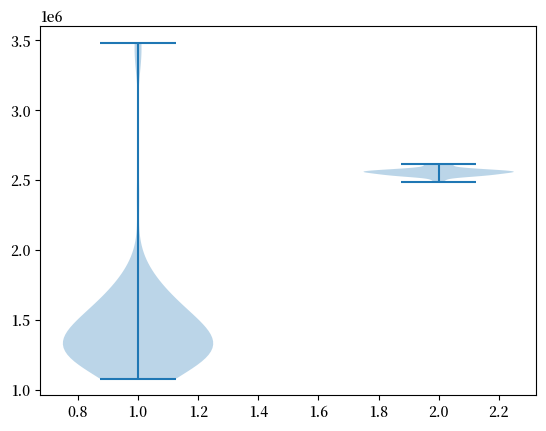

In [32]:
num_reps = 100
np.random.seed(1234)

tax_rev_lognorm = np.empty(num_reps)
tax_rev_pareto = np.empty(num_reps)

for i in range(num_reps):
    tax_rev_pareto[i] = tax_rev('pareto')
    tax_rev_lognorm[i] = tax_rev('lognorm')

fig, ax = plt.subplots()

data = tax_rev_pareto, tax_rev_lognorm

ax.violinplot(data)

plt.show()

最后，我们来生成均值和标准差。

In [33]:
tax_rev_pareto.mean(), tax_rev_pareto.std()

(1458729.0546623734, 406089.3613661567)

In [34]:
tax_rev_lognorm.mean(), tax_rev_lognorm.std()

(2556174.8615230713, 25586.44456513965)

通过查看代码的输出，我们的主要结论是，帕累托分布假设会导致更低的均值和更大的离散度。

```{solution-end}
```

```{exercise}
:label: ht_ex_cauchy

柯西分布的[特征函数](https://baike.baidu.com/item/%E7%89%B9%E5%BE%81%E5%87%BD%E6%95%B0/5126430)为

$$
\phi(t) = \mathbb E e^{itX} = \int e^{i t x} f(x) dx = e^{-|t|}
$$ (lln_cch)

证明 $n$ 次独立抽样 $X_1, \ldots, X_n$ 从柯西分布得来的样本均值 $\bar X_n$ 具有与 $X_1$ 相同的特征函数。

（这意味着样本均值永远不会收敛。）

```

```{solution-start} ht_ex_cauchy
:class: dropdown
```

由独立性，样本均值的特征函数变为

$$
\begin{aligned}
    \mathbb E e^{i t \bar X_n }
    & = \mathbb E \exp \left\{ i \frac{t}{n} \sum_{j=1}^n X_j \right\}
    \\
    & = \mathbb E \prod_{j=1}^n \exp \left\{ i \frac{t}{n} X_j \right\}
    \\
    & = \prod_{j=1}^n \mathbb E \exp \left\{ i \frac{t}{n} X_j \right\}
    = [\phi(t/n)]^n
\end{aligned}
$$

根据 {eq}`lln_cch`，这就是 $e^{-|t|}$。

因此，在柯西分布的情况下，样本均值本身具有完全相同的柯西分布，无论 $n$ 是多少！

```{solution-end}
```